Uses the modified A-matrix/b-vector formulation, and compares with the regular MEEM formulation.

In [35]:
import numpy as np
import matplotlib.pyplot as plt
from math import pi

# --- Import core modules from package ---
try:
    from openflash import *
    from openflash.multi_equations import *
    from openflash.multi_constants import g
    print("OpenFLASH modules imported successfully!")
except ImportError as e:
    print(f"Error importing OpenFLASH modules. Error: {e}")

# Set NumPy print options for better readability
np.set_printoptions(threshold=np.inf, linewidth=np.inf, precision=8, suppress=True)
from openflash.multi_equations import wavenumber

import sys
from pathlib import Path
HERE = Path.cwd().resolve()
store_path_prefix = str((HERE / "data").resolve())

slants_dir = (HERE / "..").resolve()
if str(slants_dir) not in sys.path:
    sys.path.insert(0, str(slants_dir))
from plotting_helpers import *

from modified_meem import SProblem, solve_modified_problem, slant_approx_vars, update_data_file
from helpers import *
from plotting_helpers import *
from capytaine_generator import CapytaineSlantSolver

import pickle

OpenFLASH modules imported successfully!


In [36]:
def load_data(name):
  with open(name, "rb") as f:
    data = pickle.load(f)
  return data

In [37]:
# Variable definitions: Matching most variables with the ps3 stuff.
file1 = store_path_prefix + "/ps6.pkl"

h = 100
m0 = 0.9
rho = 1023
numerators = list(range(1, 8)) + list(range(8, 16, 2)) + list(range(16, 32, 4))
# configurations = []

# for num in numerators:
#   theta = np.pi * num / 64
#   d1 = (1/np.tan(theta) * 4) + 5
#   configurations.append({"name" : "config-t-" + str(num) +"pi-64",
#                         "h" : h,
#                         "a" : [3, 7],
#                         "theta" : theta,
#                         "d_in" : [d1, d1],
#                         "d_out" : [d1, 5], 
#                         "heaving" : [0, 1],
#                         "m0" : m0, 
#                         "rho" : rho})
  
configurations = load_data(file1)

In [38]:
# Solving MEEM/capytaine functions

def make_frustrum_geometry(h, d, a, heaving, NMK):
  inner_cylinder = SteppedBody(a=np.array([a[0]]), d=np.array([d[0]]), slant_angle= np.zeros_like(np.array([a[0]])), heaving=heaving[0])
  outer_frustrum = SteppedBody(a=np.array(a[1:]), d=np.array(d[1:]), slant_angle= np.zeros_like(np.array(a[1:])), heaving=heaving[1])
  return BasicRegionGeometry(body_arrangement=ConcentricBodyGroup([inner_cylinder, outer_frustrum]), h=h, NMK=NMK)

def get_MEEM_hydros(h, omega_sweep, d_list, a_list, NMK, heaving_list):
    geometry_sweep = make_frustrum_geometry(h, d_list, a_list, heaving_list, NMK)
    problem = MEEMProblem(geometry_sweep)
    problem.set_frequencies(np.array(omega_sweep))
    engine = MEEMEngine(problem_list=[problem])

    A_MEEM = np.zeros_like(omega_sweep)
    B_MEEM = np.zeros_like(omega_sweep)

    for j in range(len(omega_sweep)):
        m0 = wavenumber(omega_sweep[j], h)
        X = engine.solve_linear_system_multi(problem, m0)
        coeffs = engine.compute_hydrodynamic_coefficients(problem, X, m0)
        A_MEEM[j] = coeffs[1]['real']
        B_MEEM[j] = coeffs[1]['imag']

    return A_MEEM, B_MEEM

def get_unmodified_MEEM_hydros(h, omega_sweep, d_in, d_out, a_list, NMK, heaving, res):
    d_prime, a_prime, heaving_prime, NMK_prime, slopes, d_in_prime, d_out_prime = slant_approx_vars(a_list, d_in, d_out, heaving, NMK, res, 2)
    A_MEEM, B_MEEM = get_MEEM_hydros(h, omega_sweep, d_prime, a_prime, NMK_prime, heaving_prime)
    return A_MEEM, B_MEEM

def get_modified_MEEM_hydros(h, omega_sweep, d_in, d_out, a_list, NMK, heaving, res, version = 2, frac1 = 0.3, frac2 = None):
    def outline_function(r):
      region = 0
      for rad in a_list:
        if r <= rad: break
        else: region += 1
      if region == len(a_list): return 0
      elif d_in[region] == d_out[region]:
        return - d_in[region]
      else:
        inner_rad = 0 if region == 0 else a_list[region - 1]
        outer_rad = a_list[region]
        slope = (d_in[region] - d_out[region])/(outer_rad - inner_rad)
        return slope * (r - inner_rad) - d_in[region]
      
    A_MEEM, B_MEEM = [], []
    for omega_val in omega_sweep:
      m0 = wavenumber(omega_val, h)
      x, cs, prob = solve_modified_problem(h, a_list, d_in, d_out, heaving, m0, rho, res, version, NMK = NMK)
      am, dp = prob.hydros_by_averages(cs, outline_function, "capytaine", frac1 = frac1, frac2 = frac2)
      A_MEEM.append(am)
      B_MEEM.append(dp)
      print(f"Finished an omega value: {omega_val:.3f}")
    return np.array(A_MEEM), np.array(B_MEEM)

def solve_box_MEEM(config, nmk = 150):
   h, d, a, heaving, m0, rho = config["h"], config["d_out"], config["a"], config["heaving"], config["m0"], config["rho"]
   NMK = [nmk, nmk, nmk]
   am, dp = get_MEEM_hydros(h, omega(m0, h, g), d, a, NMK, heaving)
   return am[0], dp[0]

css = CapytaineSlantSolver(False, False, False, False, False)

def compute_cpt_slant(config):
  t_densities = [30, 60]
  f_densities = [15, 140, 15]
  respack = css.construct_and_solve(config["a"], config["d_in"], config["d_out"], config["heaving"], t_densities, 150, config["h"], config["m0"], config["rho"], 1, f_densities)
  am, dp = (respack[0].added_mass)["Heave"], (respack[0].radiation_damping)["Heave"]
  return am, dp

In [39]:
# More specific data generation functions
# for each configuration:
# 1. get the capytaine slant values
# 2. box-configuration convergence study
# 3. run MEEM-solver for regular MEEM and slant MEEM, convergence wrt different values

def get_capytaine_data(config, configurations):
  am, dp = compute_cpt_slant(config)
  config["CPT slant AM"] = am
  config["CPT slant DP"] = dp
  update_data_file(configurations, file1)
  print("Finished " + config["name"] + "CPT slant computations.")

def box_MEEM_convergence(config, configurations):
  nmks = range(10, 301, 10)
  ams = []
  dps = []
  for nmk in nmks:
    am, dp = solve_box_MEEM(config, nmk = nmk)
    ams.append(am)
    dps.append(dp)
  config["MEEM box AMs"], config["MEEM box DPs"] = ams, dps
  update_data_file(configurations, file1)
  print("Finished " + config["name"] + "MEEM box computations.")

def make_outline(config):
  a, d_in, d_out = config["a"], config["d_in"], config["d_out"]
  def outline_function(r):
    region = 0
    for rad in a:
      if r <= rad: break
      else: region += 1
    if region == len(a): return 0
    elif d_in[region] == d_out[region]:
      return - d_in[region]
    else:
      inner_rad = 0 if region == 0 else a[region - 1]
      outer_rad = a[region]
      slope = (d_in[region] - d_out[region])/(outer_rad - inner_rad)
      return slope * (r - inner_rad) - d_in[region]
  return outline_function

def get_omega(h, m0):
  return np.sqrt(m0 * g * np.tanh( m0 * h))

def vary_res_reg(config):
  nmk = 150
  NMK = [nmk for _ in range(len(config["a"]) + 1)]
  resolutions = list(range(5, 51, 5))
  ams, dps = [], []
  for res in resolutions:
    A_MEEM, B_MEEM = get_unmodified_MEEM_hydros(config["h"], [get_omega(config["h"], config["m0"])],
                                                config["d_in"], config["d_out"],
                                                config["a"], NMK,
                                                config["heaving"], res)
    ams.append(A_MEEM[0])
    dps.append(B_MEEM[0])
  config["res MEEM regular AMs"], config["res MEEM regular DPs"] = ams, dps

def vary_res_mod(config):
  nmk = 150
  NMK = [nmk for _ in range(len(config["a"]) + 1)]
  resolutions = list(range(5, 51, 5))
  ams, dps = [], []
  for res in resolutions:
    A_MEEM, B_MEEM = get_modified_MEEM_hydros(config["h"], [get_omega(config["h"], config["m0"])],
                                              config["d_in"], config["d_out"],
                                              config["a"], NMK,
                                              config["heaving"], res)
    ams.append(A_MEEM[0])
    dps.append(B_MEEM[0])
  config["res MEEM modded AMs"], config["res MEEM modded DPs"] = ams, dps

def vary_nmk_reg(config):
  res = 30
  nmks = list(range(25, 251, 25))
  ams, dps = [], []
  for nmk in nmks:
    NMK = [nmk for _ in range(len(config["a"]) + 1)]
    A_MEEM, B_MEEM = get_unmodified_MEEM_hydros(config["h"], [get_omega(config["h"], config["m0"])],
                                                config["d_in"], config["d_out"],
                                                config["a"], NMK,
                                                config["heaving"], res)
    ams.append(A_MEEM[0])
    dps.append(B_MEEM[0])
  config["nmk MEEM regular AMs"], config["nmk MEEM regular DPs"] = ams, dps

def vary_nmk_mod(config):
  res = 30
  nmks = list(range(25, 251, 25))
  ams, dps = [], []
  for nmk in nmks:
    NMK = [nmk for _ in range(len(config["a"]) + 1)]
    A_MEEM, B_MEEM = get_modified_MEEM_hydros(config["h"], [get_omega(config["h"], config["m0"])],
                                              config["d_in"], config["d_out"],
                                              config["a"], NMK,
                                              config["heaving"], res)
    ams.append(A_MEEM[0])
    dps.append(B_MEEM[0])
  config["nmk MEEM modded AMs"], config["nmk MEEM modded DPs"] = ams, dps

In [40]:
# # Generate data (commented out)
# count = 0
# for config in configurations:
#   # Solve Capytaine Slant
#   get_capytaine_data(config, configurations)
#   # Convergence study for box-MEEM
#   box_MEEM_convergence(config, configurations)
#   # Vary res for regular MEEM
#   vary_res_reg(config)
#   update_data_file(configurations, file1)
#   print(count, "res reg")
#   # Vary res for modded MEEM
#   vary_res_mod(config)
#   update_data_file(configurations, file1)
#   print(count, "res mod")
#   # Vary nmk for regular MEEM
#   vary_nmk_reg(config)
#   update_data_file(configurations, file1)
#   print(count, "nmk reg")
#   # Vary nmk for modded MEEM
#   vary_nmk_mod(config)
#   update_data_file(configurations, file1)
#   print(count, "nmk mod")
#   count += 1

In [41]:
# Helper functions for data modification/plotting
def extract(configurations, key, length = None):
  if type(configurations[0][key]) != list:
     return [config[key] for config in configurations]
  if length is None:
     length = len(configurations[0][key])
  all_series = []
  for i in range(length):
    single_series = [config[key][i] for config in configurations]
    all_series.append(single_series)
  return all_series

def transpose(matrix):
    return [list(row) for row in zip(*matrix)]

In [42]:
# Functions for various plots

def plot1(configurations, coeff, varied):
  cpt_values = extract(configurations, "CPT slant " + coeff)
  meem_reg_values = extract(configurations, varied + " MEEM regular " + coeff + "s")
  ys = list_ratios(meem_reg_values, cpt_values)
  if varied == "res":
    labs = make_label(list(range(5, 51, 5)), "res")
    const = "nmk = 150"
  elif varied == "nmk":
    labs = make_label(list(range(25, 251, 25)), "nmk")
    const = "res = 30"
  thetas = extract(configurations, "theta")
  plot_multiple_fade(thetas, ys, labs = labs,
                     title = "Regular MEEM formulation " + coeff +"s, varying " + varied + ", " + const, xlab = "theta", ylab = "Ratio of MEEM to CPT")
  
def plot2(configurations, coeff, varied, entry):
  cpt_values = extract(configurations, "CPT slant " + coeff)
  meem_mod_lst = extract(configurations, varied + " MEEM modded " + coeff + "s")
  meem_mod_values = [[lst[entry] for lst in lst_of_lsts] for lst_of_lsts in meem_mod_lst]
  ys = list_ratios(meem_mod_values, cpt_values)
  if varied == "res":
    labs = make_label(list(range(5, 51, 5)), "res")
    const = "nmk = 150"
  elif varied == "nmk":
    labs = make_label(list(range(25, 251, 25)), "nmk")
    const = "res = 30"
  thetas = extract(configurations, "theta")
  frac = f"{((entry + 1) * 0.05):.2f}"
  plot_multiple_fade(thetas, ys, labs = labs,
                     title = "Modded MEEM formulation " + coeff +"s, varying " + varied + ", " + const + " frac = " + frac, xlab = "theta", ylab = "Ratio of MEEM to CPT")
  
def plot3(configurations, coeff, varied, index):
  # Plot the highest res/NMK values, fade over the fractions
  cpt_values = extract(configurations, "CPT slant " + coeff)
  meem_mod_high_varied = (extract(configurations, varied + " MEEM modded " + coeff + "s"))[index]
  ys = list_ratios(transpose(meem_mod_high_varied), cpt_values)
  fracs = [f"{((entry + 1) * 0.05):.2f}" for entry in range(19)]
  thetas = extract(configurations, "theta")
  labs = make_label(fracs, "frac")
  plot_multiple_fade(thetas, ys, labs = labs, title = "Modded MEEM formulation " + coeff +"s, max " + varied, xlab = "theta", ylab = "Ratio of MEEM to CPT")

def plot4(configurations, coeff): # box convergence
  meem_values = extract(configurations, "MEEM box " + coeff + "s")
  base_values = meem_values[-1]
  ys = list_ratios(meem_values, base_values)[::4]
  thetas = extract(configurations, "theta")
  labs = make_label(list(range(10, 301, 10)), "nmk")[::4]
  plot_multiple_fade(thetas, ys, labs = labs, title = "MEEM box " + coeff +"s, convergence", xlab = "theta", ylab = "Ratio of MEEM value to best MEEM")

def plot5(configurations, coeff, style, index = 5):
  # plot each data point's ratio to true value on y, delta-d on x
  cmap = plt.get_cmap("plasma")
  color_vals = np.linspace(0.8, 0.2, len(configurations))
  for j in range(len(configurations)):
    config = configurations[j]
    cpt_val = config["CPT slant " + coeff]
    xs = []
    ys = []
    for i in range(10):
      res = ( i + 1 ) * 5
      x = (config["d_in"][0] - 5) / res
      if style == "regular":
        y = (config["res MEEM " + style + " " + coeff + "s"][i])/cpt_val
      elif style == "modded":
        y = (config["res MEEM " + style + " " + coeff + "s"][i][index])/cpt_val
      xs.append(x)
      ys.append(y)
    num = round(config["theta"] / pi * 64)
    lab = f"{num}π/{64}"
    plt.plot(xs, ys, label = lab, color=cmap(color_vals[j]))
  plt.legend()
  plt.xlabel("delta-d")
  plt.ylabel("ratio to Capytaine value")
  plt.title(coeff + " closeness dependence on delta-d (NMK = 150), " + style + " MEEM")
  plt.grid(True)
  plt.show()

def plot6(configurations, coeff, index = 5):
  # plot each data point's ratio to true value on y, delta-d on x
  cmap1 = plt.get_cmap("viridis")
  color_vals1 = np.linspace(0.8, 0.2, len(configurations))
  cmap2 = plt.get_cmap("magma")
  color_vals2 = np.linspace(0.8, 0.2, len(configurations))
  for j in range(len(configurations)):
    config = configurations[j]
    cpt_val = config["CPT slant " + coeff]
    xs = []
    y1s = []
    y2s = []
    for i in range(10):
      res = ( i + 1 ) * 5
      x = (config["d_in"][0] - 5) / res
      y1 = (config["res MEEM regular " + coeff + "s"][i])/cpt_val
      y2 = (config["res MEEM modded " + coeff + "s"][i][index])/cpt_val
      xs.append(x)
      y1s.append(y1)
      y2s.append(y2)
    num = round(config["theta"] / pi * 64)
    lab1 = f"{num}π/{64} reg"
    lab2 = f"{num}π/{64} mod"
    plt.plot(xs, y1s, label = lab1, color=cmap1(color_vals1[j]))
    plt.plot(xs, y2s, label = lab2, color=cmap2(color_vals2[j]))
  plt.legend()
  plt.xlabel("delta-d")
  plt.ylabel("ratio to Capytaine value")
  plt.title(coeff + " closeness dependence on delta-d (NMK = 150)")
  plt.grid(True)
  plt.show()


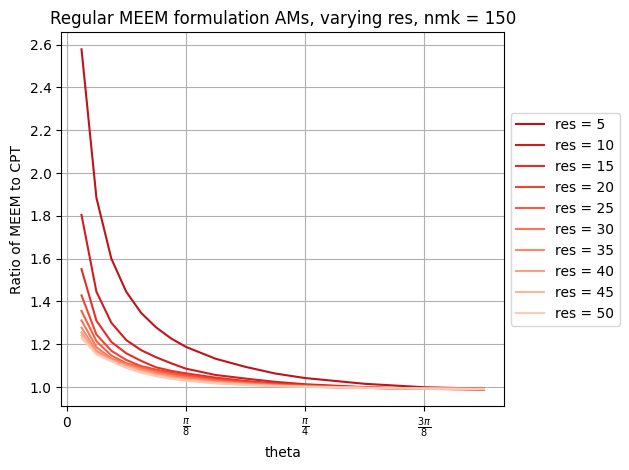

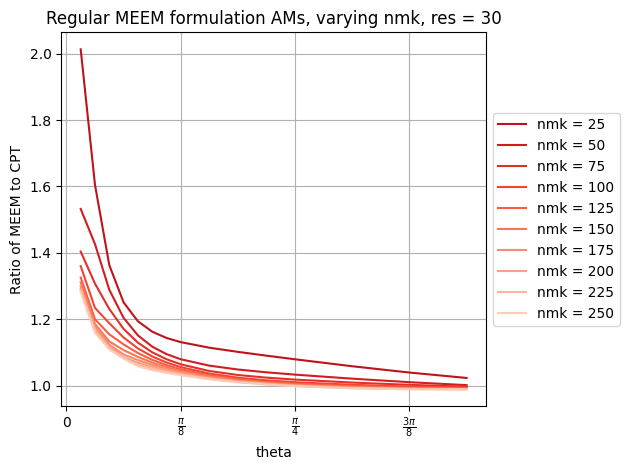

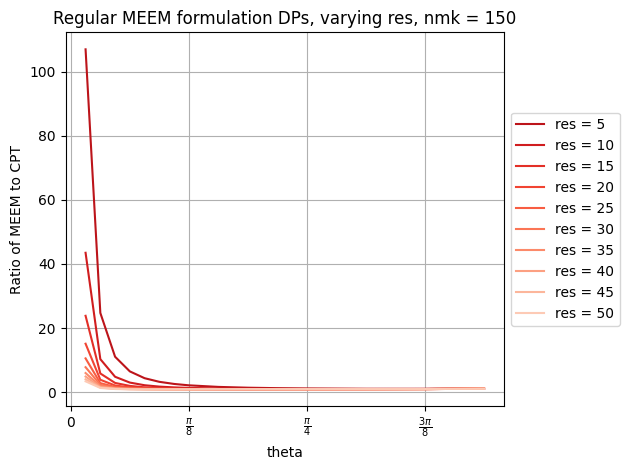

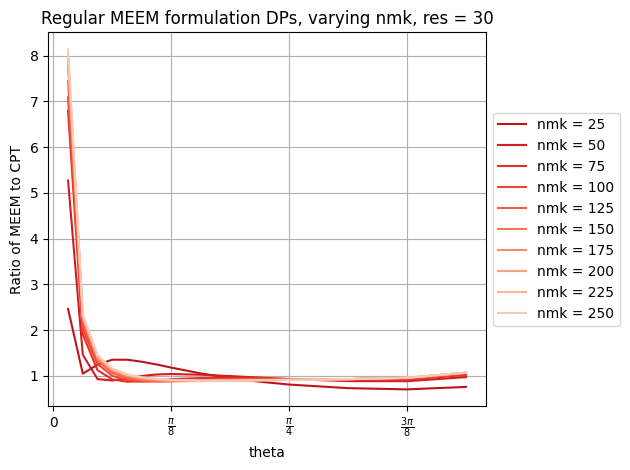

In [43]:
plot1(configurations, "AM", "res")
plot1(configurations, "AM", "nmk")
plot1(configurations, "DP", "res")
plot1(configurations, "DP", "nmk")

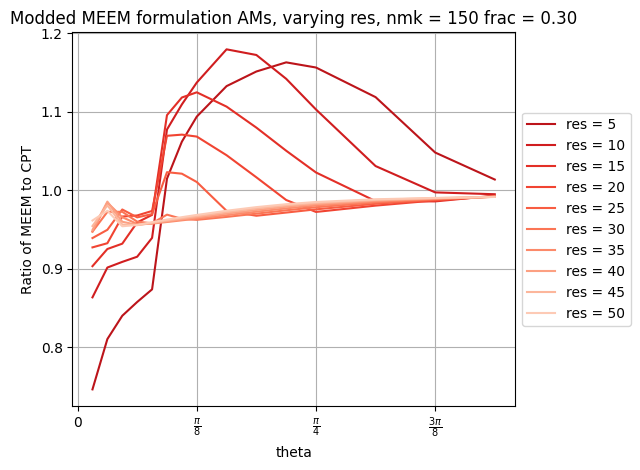

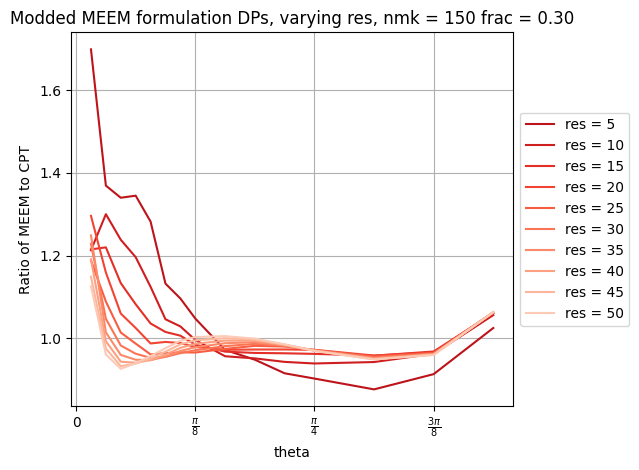

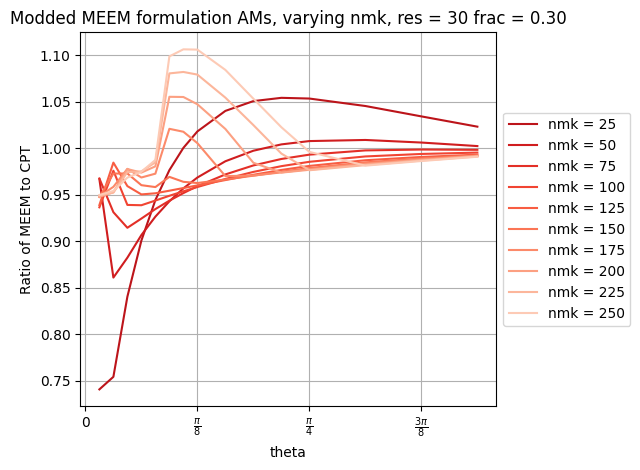

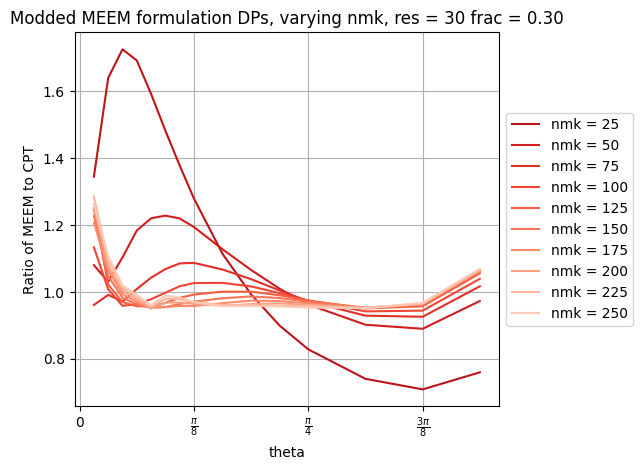

In [28]:
plot2(configurations, "AM", "res", 5)
plot2(configurations, "DP", "res", 5)
plot2(configurations, "AM", "nmk", 5)
plot2(configurations, "DP", "nmk", 5)

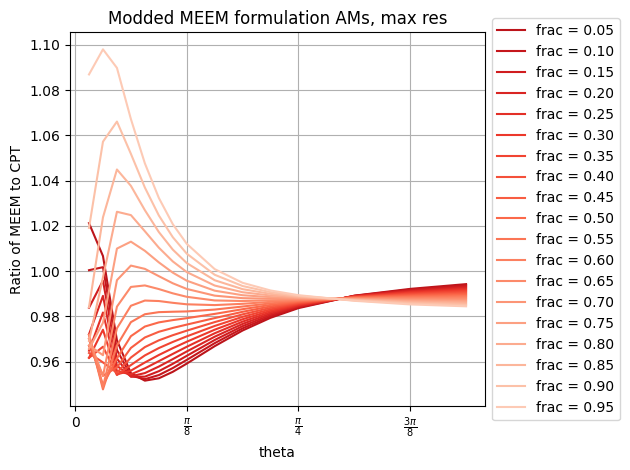

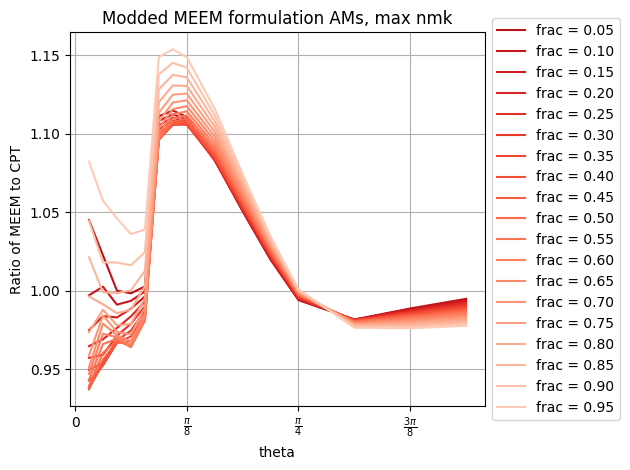

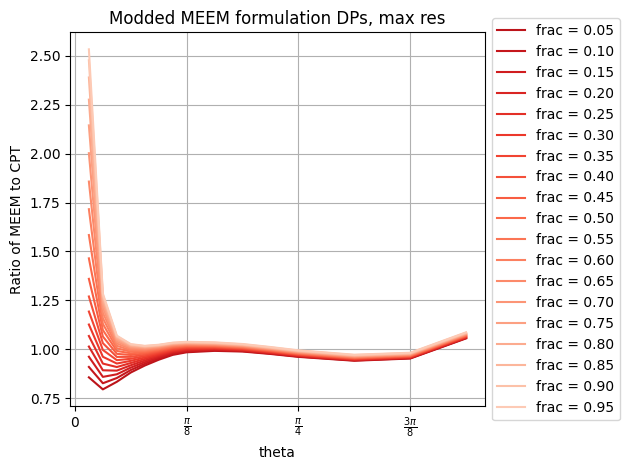

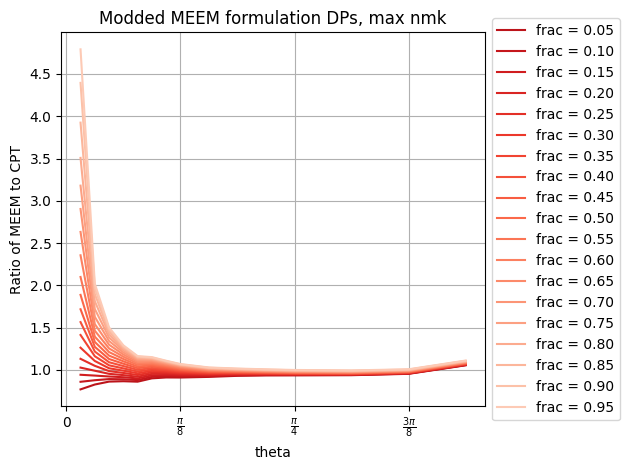

In [29]:
plot3(configurations, "AM", "res", -1)
plot3(configurations, "AM", "nmk", -1)
plot3(configurations, "DP", "res", -1)
plot3(configurations, "DP", "nmk", -1)

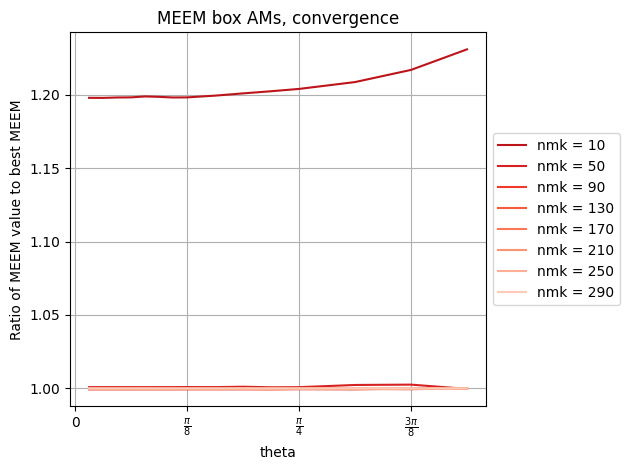

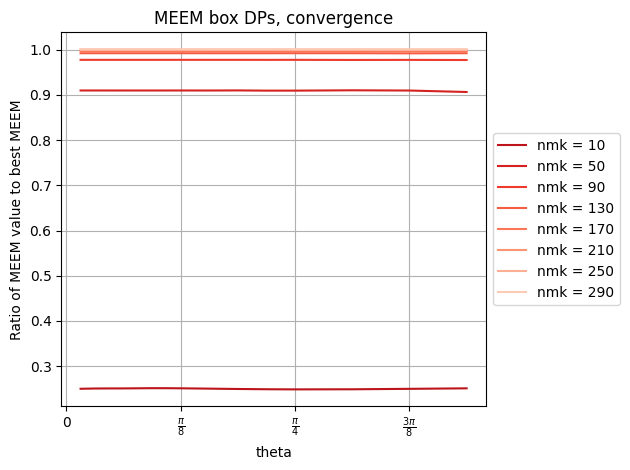

In [30]:
plot4(configurations, "AM")
plot4(configurations, "DP")

# Note: NMK convergence for these is a lot better than for the slants.
# (h-d)/radwidth reasons

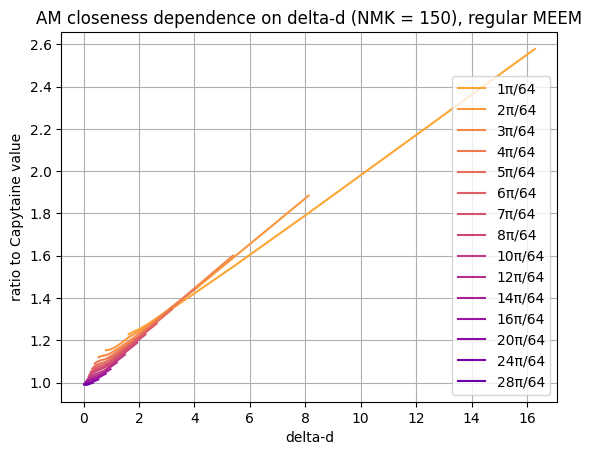

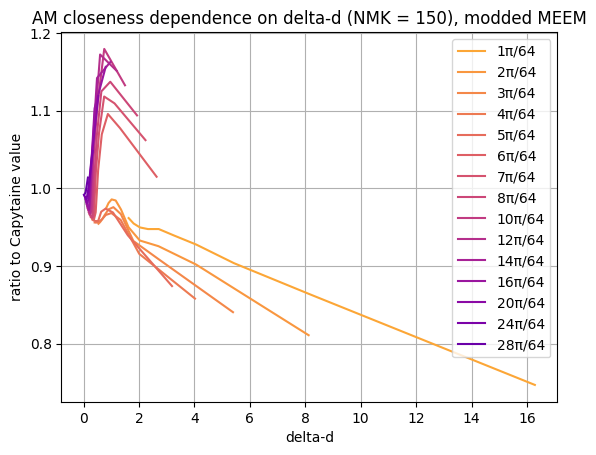

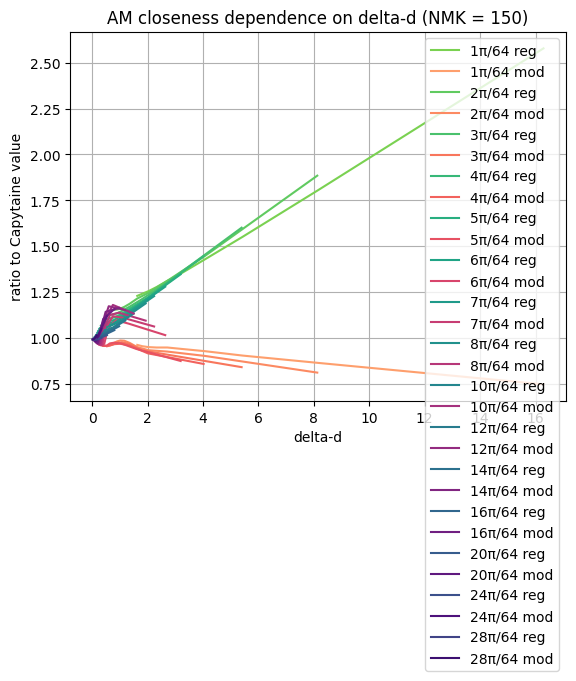

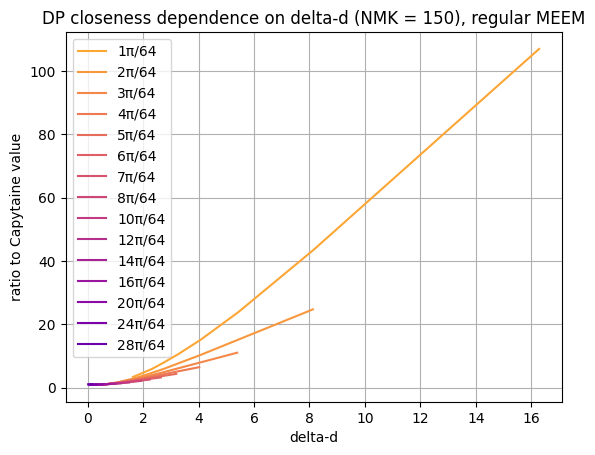

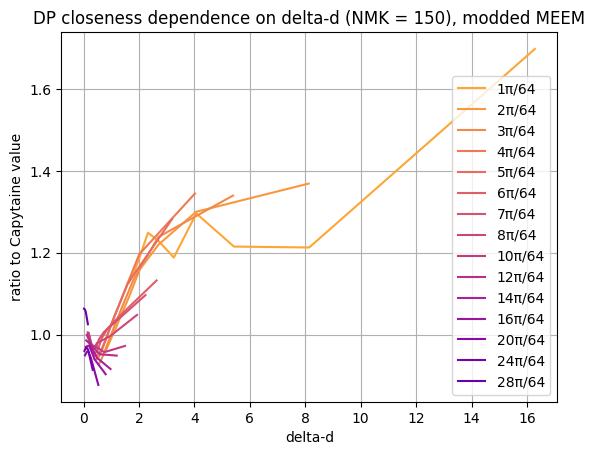

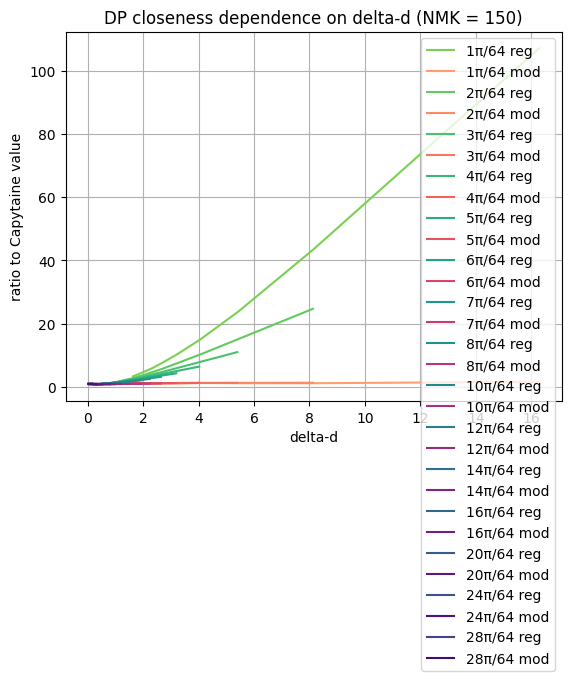

In [31]:
plot5(configurations, "AM", "regular")
plot5(configurations, "AM", "modded")
plot6(configurations, "AM")
plot5(configurations, "DP", "regular")
plot5(configurations, "DP", "modded")
plot6(configurations, "DP")